In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score,confusion_matrix, make_scorer, precision_recall_curve, roc_auc_score, classification_report, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from hyperopt import fmin, tpe, hp, Trials
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/test.csv
/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv


In [2]:
df = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')

Definindo a função de lucro usando a matrix de confusão. 

In [3]:
def lucro(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    fp = conf_matrix[0][1]
    vp = conf_matrix[1][1]
    
    return  90*vp - 10*fp 


Dividindo 20% da base para teste, e o resto para treino. 

In [4]:
X = df.drop(['ID','TARGET'], axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 17) 

Distribuição da Target.

In [6]:
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

0    0.960816
1    0.039184
Name: TARGET, dtype: float64
0    0.958892
1    0.041108
Name: TARGET, dtype: float64


Podemos observar que a target é bem desbalanceada, devido a isso deveremeos modificar alguns parametros no algoritmo de aprendizagem para dar mais pesoas às classes positivas.

Utilizaremos o random forest para fazer um feature selection maximizando o AUC e selecionando as variaveis com a maior relevância no modelo usando uma importancia de corte baseada na media de todas importancias das variaveis e um multiplicador ótimo definido pelo hyperopt.

In [ ]:
SPACO = {
    'thr': hp.quniform('thr', 1, 9, 0.5)
}
    
def thr_opt(params):
    
    thr = params['thr']
    
    rf = RandomForestClassifier(class_weight = 'balanced')
    sel = SelectFromModel(rf,threshold = '{0}*mean'.format(thr))
    sel.fit(X_train, y_train)

    X_train_thr = X_train.loc[:, sel.get_support()] 
    X_test_thr = X_test.loc[:, sel.get_support()] 
    
    y_pred_thr = rf.fit(X_train_thr, y_train).predict(X_test_thr)
    auc = roc_auc_score(y_test, y_pred_thr)
    
    
    return -1*auc

trials = Trials()
best_thr=fmin(fn = thr_opt, 
          space = SPACO, 
          algo = tpe.suggest, 
          max_evals = 50, 
          trials = trials, 
         )

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

In [ ]:
best_thr

Depois de algumas execuções escolhemos o multiplicador 5 devido a expectativa que o algoritmo de treinamento que vai ser usado(xgboost) pode extrair mais informações das variaveis que seriam eliminadas pelo RF.
No final, ficamos com 14 variaveis que juntas performam igual a um modelo com todas as features presentes na base.

In [9]:
rf = RandomForestClassifier(class_weight = 'balanced')
thr = 5
sel = SelectFromModel(rf,threshold = '{0}*mean'.format(thr))
sel.fit(X_train, y_train)

X_train = X_train.loc[:, sel.get_support()] 
X_test = X_test.loc[:, sel.get_support()] 

dtrain = xgb.DMatrix(X_train, label = y_train) 
dtest = xgb.DMatrix(X_test, label = y_test)

evallist = [(dtest, 'eval'),(dtrain, 'train')]

Plotando a importancia de cada variavel que entrou no modelo.

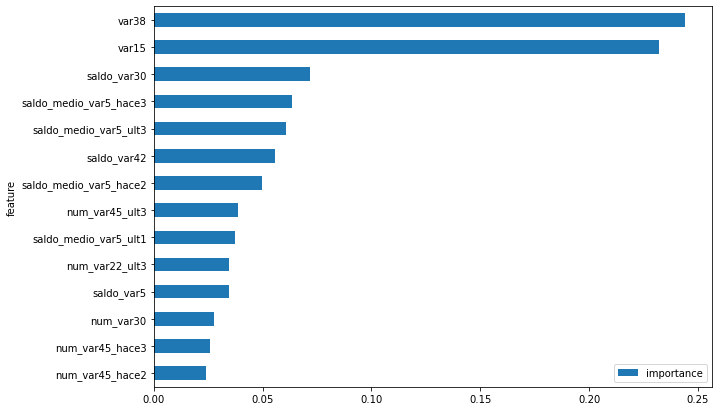

In [15]:
peso_features = rf.fit(X_train,y_train).feature_importances_
features ={
    'feature':X_train.columns,
    'importance':peso_features
}
pd.DataFrame(data=features, columns=['feature',"importance"]).set_index('feature').sort_values(by='importance').plot.barh(figsize=(10,7))

Vamos testar o Xgboost sem nenhuma otimização para usar de baseline.

In [23]:

params={'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster' : 'gbtree'}

num_round = 200
early_stopping_rounds = 20


classificador = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = early_stopping_rounds, verbose_eval=False)

y_pred = (classificador.predict(dtest) > 0.5)*1

print("Lucro: {0}".format(lucro(y_test, y_pred)))
print("Porcentagem do total: {}%".format(round((lucro(y_test, y_pred)/np.sum(y_test*90))*100),2))


Lucro: 550
Porcentagem do total: 1.0%


Conseguimos apenas 1% do lucro total usando o modelo padrão. Vamos utilizar o hyperopt para otimizar os parâmetros do Xgboost

Agora vamos definir a função de lucro que deve ser otimizada para retornar o lucro maximo, e o espaço de parametros que o hyperopt vai percorrer para conseguir o melhor modelo preditivo para alimentar essa função. 

In [ ]:
PARAMS_ESTATICOS = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster' : 'gbtree'}

SPACO = {
    'eta': hp.quniform('eta', 0, 1, 0.01),
    'max_depth': hp.quniform('max_depth', 2, 30, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.7, 1, 0.1),
    'colsample_bylevel': hp.quniform('colsample_bylevel', 0.7, 1, 0.1),
    'colsample_bynode' : hp.quniform('colsample_bynode', 0.7, 1, 0.1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 30, 0.5),
    'lambda': hp.quniform('lambda', 0.0, 1, 0.01),
    'alpha': hp.quniform('alpha', 0.0, 1, 0.01)
    }                  

def objetivo(params):

    num_round = 200
    early_stopping_rounds = 20
    
#     params['scale_pos_weight'] = int(params['scale_pos_weight'])
    params['max_depth'] = int(params['max_depth'])
    
    todos_param = {**params, **PARAMS_ESTATICOS}
    evallist = [(dtest, 'eval'),(dtrain, 'train')]

    classificador = xgb.train(todos_param, dtrain, num_round, evallist, early_stopping_rounds = early_stopping_rounds , verbose_eval= False)
    print(params)
    
    y_pred = (classificador.predict(dtest) > 0.5)*1
    
    return -1*lucro(y_test, y_pred)


trials = Trials()
best = fmin(fn = objetivo, 
          space = SPACO, 
          algo = tpe.suggest, 
          max_evals = 1000, 
          trials = trials, 
         )   

Variação dos parametros em cada iteração do hyperopt

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f995a3790>,
      dtype=object)

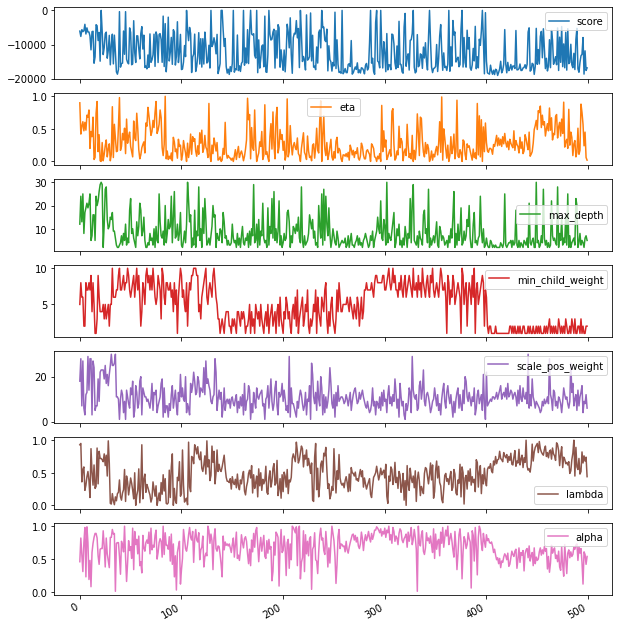

In [14]:
tpe_results = np.array([[x['result']['loss'],
                      x['misc']['vals']['eta'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_weight'][0],
                      x['misc']['vals']['scale_pos_weight'][0],
                      x['misc']['vals']['lambda'][0],
                      x['misc']['vals']['alpha'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                           columns=['score', 'eta', 'max_depth', 'min_child_weight','scale_pos_weight', 'lambda', 'alpha'])
tpe_results_df.plot(subplots=True,figsize=(10, 12))

Depois de 1000 iterações encontramos o melhor conjunto de parametros.

In [22]:
best

{'alpha': 0.25,
 'colsample_bylevel': 0.7000000000000001,
 'colsample_bynode': 0.7000000000000001,
 'colsample_bytree': 1.0,
 'eta': 0.1,
 'lambda': 0.23,
 'max_depth': 4.0,
 'min_child_weight': 1.0,
 'scale_pos_weight': 10.5,
 'subsample': 0.6000000000000001}

Vamos treinar o modelo com os melhores parametros encontrados.

In [26]:

params={'alpha': 0.25,
 'colsample_bylevel': 0.7000000000000001,
 'colsample_bynode': 0.7000000000000001,
 'colsample_bytree': 1.0,
 'eta': 0.1,
 'lambda': 0.23,
 'max_depth': 4,
 'min_child_weight': 1.0,
 'scale_pos_weight': 10.5,
 'subsample': 0.6000000000000001, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster' : 'gbtree'}

num_round = 200
early_stopping_rounds = 20
evals_results = {}


classificador = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds = early_stopping_rounds, evals_result = evals_results, verbose_eval=False)

y_pred = (classificador.predict(dtest) > 0.5)*1

print("Lucro: {0}".format(lucro(y_test, y_pred)))
print("Porcentagem do total: {}%".format(round((lucro(y_test, y_pred)/np.sum(y_test*90))*100)))


Lucro: 17350
Porcentagem do total: 31.0%


Com o modelo otimizado conseguimos um lucro mais de 31 vezes maior do que o modelo baseline.

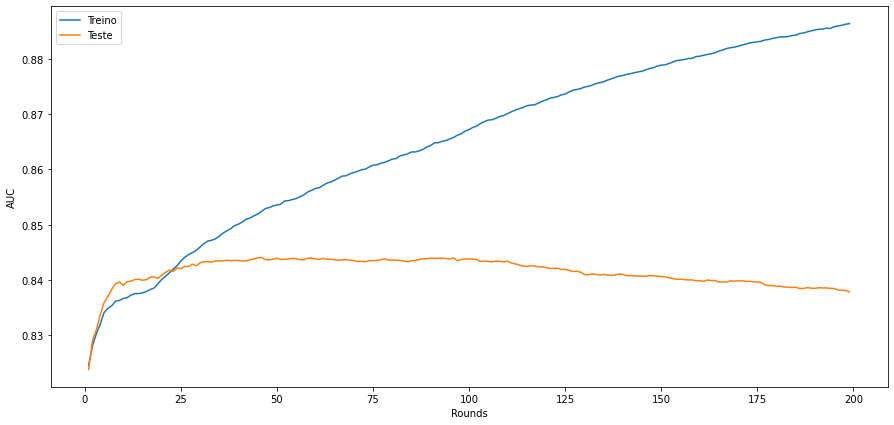

In [31]:
graf_train = pd.DataFrame.from_dict(evals_results['train'])
graf_eval = pd.DataFrame.from_dict(evals_results['eval'])

iterations = np.arange(1, 200, dtype=int)

plt.figure(figsize=(15,7))
plt.plot(iterations,graf_train[1:],label='Treino')
plt.plot(iterations,graf_eval[1:], label = 'Teste')
plt.xlabel('Rounds')
plt.ylabel('AUC')
plt.legend()

Agora vamos definir o melhor ponto de corte para lucratividade no nosso modelo.

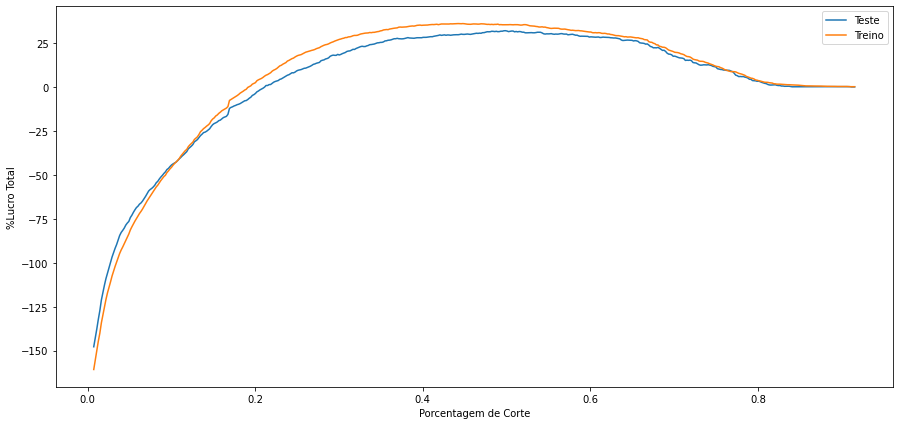

In [45]:
y_pred = classificador.predict(dtest)
y_pred_train = classificador.predict(dtrain)

pr, recall, thr = precision_recall_curve(y_test, y_pred)
pr_train, recall_train, thr_train = precision_recall_curve(y_train, y_pred_train)

pts_corte = np.linspace(np.min(thr),np.max(thr),500)

lucro_por_corte = [lucro(y_test, (y_pred > i)*1)/(y_test.sum()*90)*100 for i in pts_corte]
lucro_por_corte_train = [lucro(y_train, (y_pred_train > i)*1)/(y_train.sum()*90)*100 for i in pts_corte]

plt.figure(figsize=(15,7))
plt.plot(pts_corte, lucro_por_corte, label='Teste')
plt.plot(pts_corte, lucro_por_corte_train, label='Treino')
plt.ylabel('%Lucro Total')
plt.xlabel('Porcentagem de Corte')
plt.legend()

In [42]:
corte_lucro_maximo = pts_corte[np.argmax(lucro_por_corte)]
print(corte_lucro_maximo)

0.4985799554069126


No final chegamos ao ponto de corte de 49,8%.

In [47]:
print(classification_report(y_test, (y_pred > corte_lucro_maximo)*1) )

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     14579
           1       0.19      0.60      0.29       625

    accuracy                           0.88     15204
   macro avg       0.59      0.75      0.61     15204
weighted avg       0.95      0.88      0.91     15204



Agora a dividiremos os clientes em uma pontuação de 1 a 5 baseando-se no ponto de corte encontrado anteriormente.

Text(0.5, 0, 'Score')

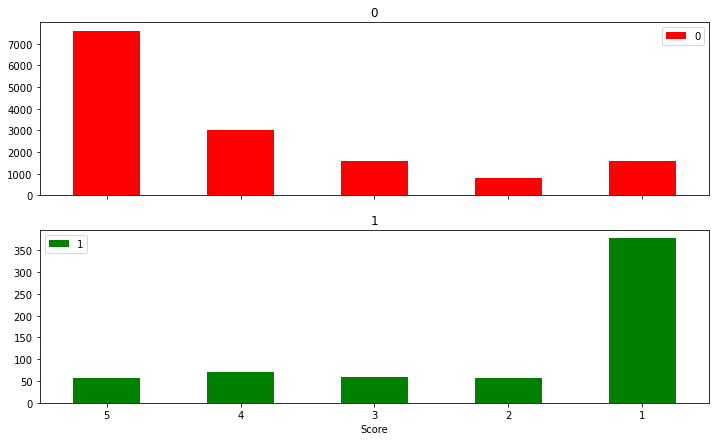

In [65]:

score = pd.cut(y_pred, bins=list(np.linspace(0,corte_lucro_maximo,5))+[1.0], labels=[5,4,3,2,1])
pd.concat((pd.Series(score, name='score'), y_test.reset_index(drop=True)), axis=1, ignore_index=False).groupby(['TARGET','score']).size().unstack('TARGET').plot.bar(subplots=True,figsize = (12,7), color={0: "red", 1: "green"})
plt.xticks(rotation=0)
plt.xlabel('Score')

Como podemos observar no gráfico acima, o modelo faz uma boa divisão dos clientes satisfeitos e insatisfeitos mesmo as categorias sendo bem desbalanceadas nas suas quantidades.

Agora vamos tentar achar o 3 melhores cluster usando um metodo de treino não supervisionado.

In [106]:
X = df.drop(['ID','TARGET'], axis=1)
y = df['TARGET']

selector = VarianceThreshold().fit(X)

X_var = X.loc[:, selector.get_support()]

corr_matrix = X_var.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

X = X.drop(df[to_drop], axis=1)
print("Features: {0}".format(X.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 17) 

Features: 166


Primeiramente dropamos as features com pouca variação e muito correlacionadas.

0.9721110054065745


Text(0.5, 0, '%variancia explicada')

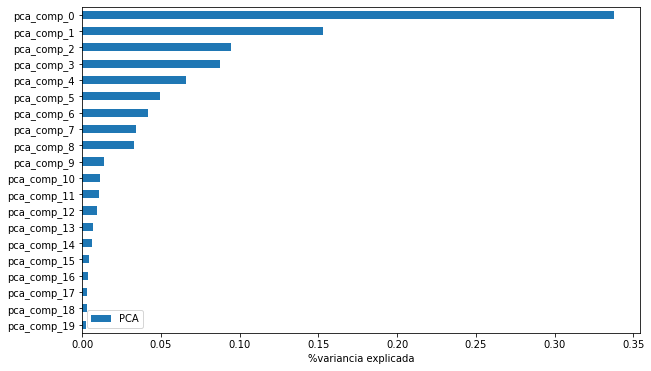

In [122]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

X_train_sca = sc.fit_transform(X_train)
X_test_sca = sc.transform(X_test)

pca = PCA(n_components=20)

X_train_pca = pca.fit_transform(X_train_sca)
X_test_pca = pca.transform(X_test_sca)

print("% da Variância total: {0}".format(np.sum(pca.explained_variance_ratio_)))

pca_comp = ['pca_comp_{}'.format(str(i)) for i in range(20)]
pd.DataFrame(pca.explained_variance_ratio_, index=pca_comp, columns = ['PCA']).sort_values(by='PCA').plot.barh(figsize=(10,6))
plt.xlabel('%variancia explicada')

Usamos o PCA e escolhmenos os 20 melhores componentes basenado-se na variancia total explicada por eles.

In [162]:
cluster = [KMeans(n_clusters=i, n_init = 20 ,random_state=17).fit(X_train_pca) for i in range(3,20)]
silhueta = [silhouette_score(X_train_pca,cl.labels_) for cl in cluster]

cl_melhor_silh = np.argmax(silhueta)
print("Melhor numero de clusters: {0}".format(cl_melhor_silh+3))


Melhor numero de clusters: 19


Fazemos clusterização usando o Kmeans, e escolhemos o numero de cluster que nos da a melhor silhueta, e por fim fazemos a avaliação de lucro por cluster.

In [163]:
cl = cluster[cl_melhor_silh].predict(X_test_pca)

df_kmeans = pd.DataFrame({'Cluster': cl, 'Target': y_test})

tb_valid = pd.crosstab(df_kmeans['Cluster'],df_kmeans['Target'])

tb_valid['volumetria'] = tb_valid[0]+tb_valid[1]
tb_valid['lucro'] = tb_valid[1]*90 - tb_valid[0]*10
tb_valid['%lucro_total'] = round(tb_valid['lucro']/(sum(tb_valid[1])*90)*100,2)
tb_valid.sort_values(by='%lucro_total', ascending=False)


Target,0,1,volumetria,lucro,%lucro_total
Cluster,,,,,
4,775,97,872,980,1.74
9,326,32,358,-380,-0.68
6,59,0,59,-590,-1.05
18,181,13,194,-640,-1.14
14,140,1,141,-1310,-2.33
11,164,2,166,-1460,-2.60
16,191,5,196,-1460,-2.60
13,176,1,177,-1670,-2.97
8,189,1,190,-1800,-3.20


Conforme podemos observar, somente o primeiro cluster nos da um lucro positivo, mas como se observa uma piora do lucro crescente escholheria os clusters 4, 9 e 6 como os três grupos naturais de maior lucro.